In [1]:
! pip install import-ipynb


You should consider upgrading via the 'C:\Users\aymen\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


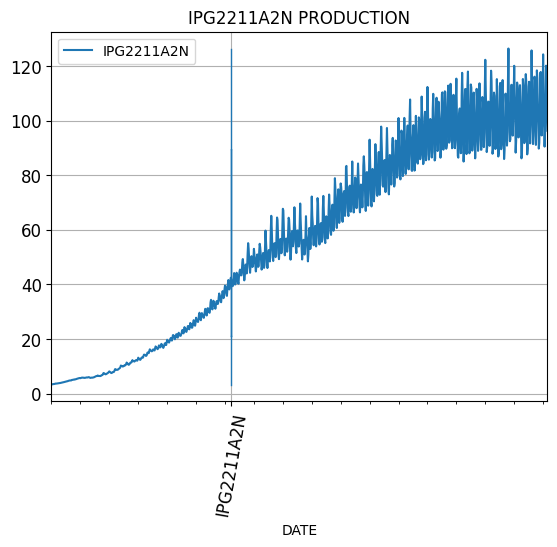

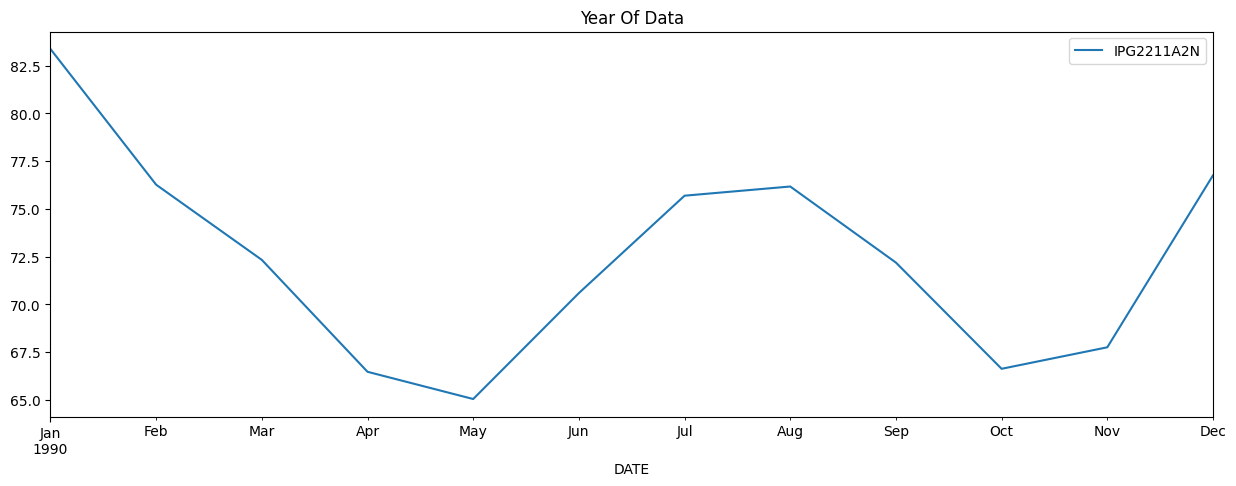

X_train shape before reshape: (814, 12, 1), X_test shape before reshape: (204, 12, 1)
X_train shape after reshape: (814, 12, 1), X_test shape after reshape: (204, 12, 1)


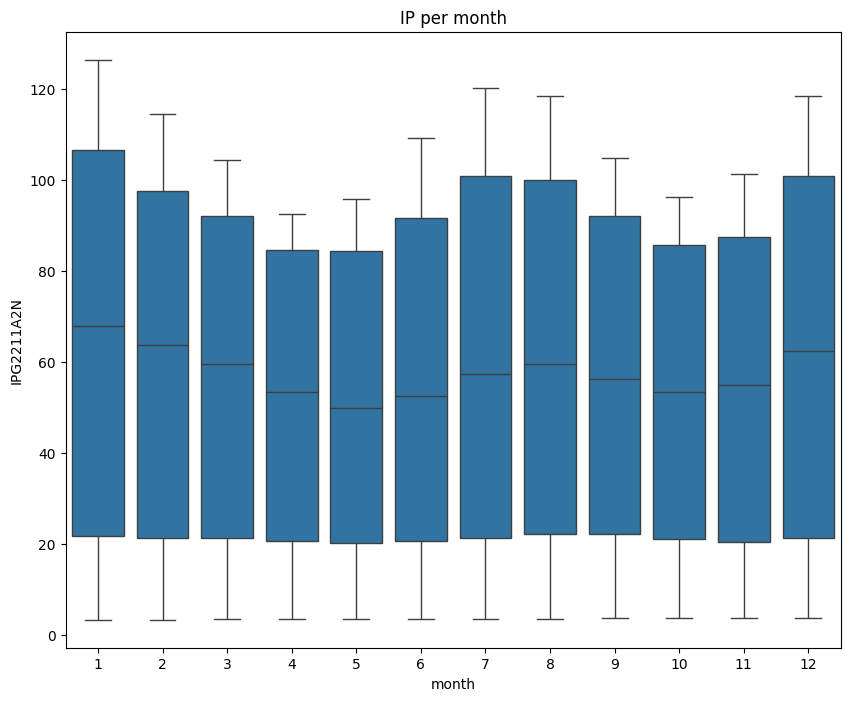

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import import_ipynb
from data_preparation import Data
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer



from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error

import itertools

import warnings
warnings.filterwarnings('ignore')

In [3]:
path = "../data/IPG2211A2N.csv"
d1 = Data(path)
df = d1.read_data()
X, y = d1.create_features(df ,'IPG2211A2N' )


In [4]:
def plot_forecasts(y_test, y_pred):
    plt.plot(y_test, label='True Values')
    plt.plot(y_pred, label='Predictions')
    plt.legend()
    return plt.show()

## Model selection

As mentioned in the previous notebook, we will add the previous 12 values as new columns. Since we are working with time series data, LSTM models are well-suited for this task.

#### 1- LSTM Model

In [5]:
X, y = d1.create_features(df ,'IPG2211A2N' )
# Split into training and testing sets
split_index = int(len(X) * 0.8)  # Use 80% for training, 20% for testing
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Check the shapes of the datasets before reshaping for LSTM
print(f"X_train shape before reshape: {X_train.shape}, X_test shape before reshape: {X_test.shape}")

# Reshape input data for LSTM (3D shape: [samples, time_steps, features])
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  # Adding '1' as the number of features
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Check the shapes after reshaping
print(f"X_train shape after reshape: {X_train.shape}, X_test shape after reshape: {X_test.shape}")

X_train shape before reshape: (814, 12, 1), X_test shape before reshape: (204, 12, 1)
X_train shape after reshape: (814, 12, 1), X_test shape after reshape: (204, 12, 1)


In [6]:
def LSTM_model(optimizer='adam', units=80, dropout_rate=0.3):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units, return_sequences=False))  # Final LSTM layer
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error',metrics=[RootMeanSquaredError()] )
    return model


To improve the model's ability to learn from data, cross-validation techniques are essential. Time Series Cross-Validation (TSCV) adapts traditional cross-validation methods to account for the temporal structure of time series data. Unlike standard cross-validation, which uses random splits, TSCV maintains the chronological order of observations. This approach ensures that the model is trained on past data and tested on future data, closely simulating real-world scenarios.


In [7]:
def cross_validation(model, n_splits, epochs, batch_size):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    split = 1
    # Initialize lists to store RMSE values
    train_rmse_history = []
    val_rmse_history = []
    for train_index, test_index in tscv.split(X):
        print(f"Split {split}:")
        split += 1
        # Split data
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # Train the model with validation data
       
        history = model.fit(
            X_train, y_train, 
            epochs=epochs, 
            batch_size=batch_size, 
            validation_data=(X_test, y_test), 
            verbose=1
        )
        # Collect training and validation RMSE
        train_rmse = [np.sqrt(mse) for mse in history.history['loss']]
        val_rmse = [np.sqrt(mse) for mse in history.history['val_loss']]
        train_rmse_history.append(train_rmse)
        val_rmse_history.append(val_rmse)
        print("-" * 50)
    # Plot RMSE for all splits
    plt.figure(figsize=(12, 6))
    plt.plot(train_rmse_history[-1], label=f'Train Split {5}', linestyle='--')
    plt.plot(val_rmse_history[-1], label=f'Val Split {5}')
    plt.title('Training and Validation RMSE for the last split')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid()
    plt.show()



Next, we proceed to the prediction phase. Before interpreting the results, it is necessary to rescale the data to its original scale. This is achieved using the "scaler.inverse_transform" function, which restores the data to its normal form.

In [8]:
def predict_model(model):
    """ Make predictions """
    y_pred = model.predict(X_test)
    # Inverse transform predictions and true values for comparison
    y_pred_rescaled = d1.scaler.inverse_transform(y_pred)
    y_test_rescaled = d1.scaler.inverse_transform(y_test)
    return y_pred_rescaled , y_test_rescaled



In [9]:
lstm_model = LSTM_model()
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 80)            26240     
                                                                 
 dropout (Dropout)           (None, 12, 80)            0         
                                                                 
 lstm_1 (LSTM)               (None, 80)                51520     
                                                                 
 dropout_1 (Dropout)         (None, 80)                0         
                                                                 
 dense (Dense)               (None, 1)                 81        
                                                                 
Total params: 77,841
Trainable params: 77,841
Non-trainable params: 0
_________________________________________________________________


Split 1:
Epoch 1/25
6/6 [==============================] - 4s 163ms/step - loss: 7.2087e-04 - root_mean_squared_error: 0.0268 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0924
Epoch 2/25
6/6 [==============================] - 0s 25ms/step - loss: 2.9679e-04 - root_mean_squared_error: 0.0172 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0796
Epoch 3/25
6/6 [==============================] - 0s 26ms/step - loss: 1.4309e-04 - root_mean_squared_error: 0.0120 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0372
Epoch 4/25
6/6 [==============================] - 0s 21ms/step - loss: 6.0118e-05 - root_mean_squared_error: 0.0078 - val_loss: 9.9321e-05 - val_root_mean_squared_error: 0.0100
Epoch 5/25
6/6 [==============================] - 0s 24ms/step - loss: 3.2859e-05 - root_mean_squared_error: 0.0057 - val_loss: 2.2518e-04 - val_root_mean_squared_error: 0.0150
Epoch 6/25
6/6 [==============================] - 0s 24ms/step - loss: 2.8247e-05 - root_mean_squared_error: 0.0053 -

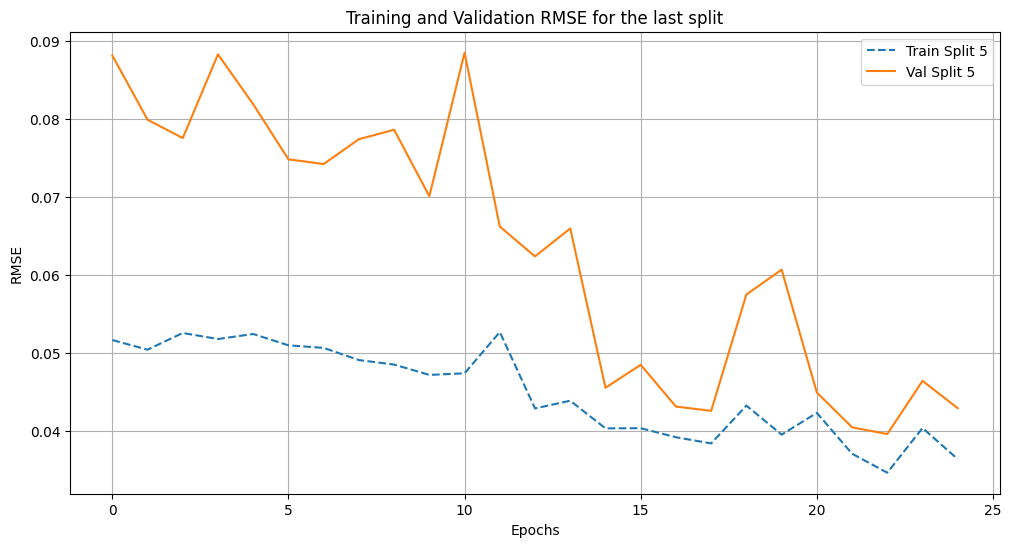

In [10]:
cross_validation(lstm_model, 5,25,32)

The training and validation curves converge to the same value and the distance between them diminishes. This indicates that the model is generalizing well. This behavior suggests that the model is learning the underlying patterns in the data effectively, and it is not overfitting or underfitting.

7/7 [==============================] - 1s 7ms/step


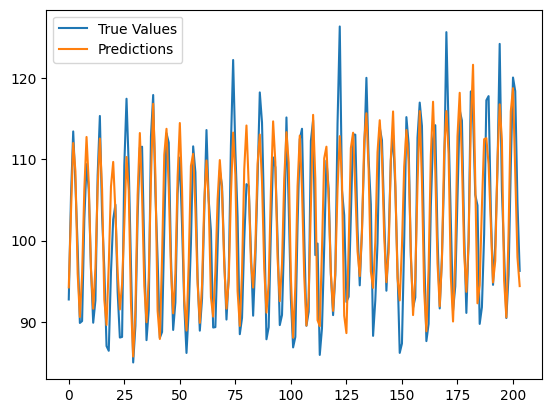

Mean Absolute Error (MAE): 4.029171847833371
Root mean sqared error(RMSE): 5.136547069247817


: 

In [ ]:
y_pred_rescaled , y_test_rescaled = predict_model(lstm_model)
plot_forecasts(y_test_rescaled,y_pred_rescaled )
# Calculate error metrics
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = root_mean_squared_error(y_test_rescaled, y_pred_rescaled)

print("Mean Absolute Error (MAE):", mae)
print("Root mean sqared error(RMSE):", rmse)

To improve the model's performance, we will explore the optimal parameters for the model.

##### Finding the Best Parameters for the LSTM Model

In [13]:
# Wrap the model into KerasRegressor for use with RandomizedSearchCV
model = KerasRegressor(build_fn=LSTM_model, verbose=0)

param_dist = {
    'units': [80, 100],  # Smaller range for units
    'dropout_rate': [0.2, 0.3],  # Keep dropout rate more conservative
    'epochs': [25,30],  # Fix epochs at a reasonable number
    'batch_size': [32]  # Fix batch size for consistency
}

# Callbacks for early stopping and learning rate reduction
callbacks = [
   EarlyStopping(monitor='loss', patience=5, restore_best_weights=True),  
   ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3) 
]

# Define TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=3)

# Scoring Function for RMSE
def neg_rmse(y_true, y_pred):
    return -np.sqrt(np.mean((y_true - y_pred) ** 2))

scoring = make_scorer(neg_rmse, greater_is_better=False)

# RandomizedSearchCV with TimeSeriesSplit
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=5,
    cv=tscv,
    scoring=scoring,  # Custom RMSE scorer
    verbose=1
)

# Fit the model with RandomizedSearchCV
random_search_result = random_search.fit(X_train, y_train, callbacks=callbacks)

# Print the best parameters and score
print("Best Parameters:", random_search_result.best_params_)
print("Best RMSE:", -random_search_result.best_score_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Parameters: {'units': 100, 'epochs': 30, 'dropout_rate': 0.2, 'batch_size': 32}
Best RMSE: -0.10474309463946656


In [14]:
units = random_search_result.best_params_['units']  
epochs =  random_search_result.best_params_['epochs'] 
batch_size =   random_search_result.best_params_['batch_size'] 
dropout_rate =   random_search_result.best_params_['dropout_rate'] 
# Print the best parameters
print("Best parameters:", random_search_result.best_params_)
print(( units, dropout_rate , epochs , batch_size))

Best parameters: {'units': 100, 'epochs': 30, 'dropout_rate': 0.2, 'batch_size': 32}
(100, 0.2, 30, 32)


Split 1:
Epoch 1/30
6/6 [==============================] - 9s 362ms/step - loss: 7.0918e-04 - root_mean_squared_error: 0.0266 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0940
Epoch 2/30
6/6 [==============================] - 1s 154ms/step - loss: 2.8385e-04 - root_mean_squared_error: 0.0168 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0774
Epoch 3/30
6/6 [==============================] - 1s 154ms/step - loss: 1.3607e-04 - root_mean_squared_error: 0.0117 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0419
Epoch 4/30
6/6 [==============================] - 1s 154ms/step - loss: 4.8292e-05 - root_mean_squared_error: 0.0069 - val_loss: 7.0045e-05 - val_root_mean_squared_error: 0.0084
Epoch 5/30
6/6 [==============================] - 1s 155ms/step - loss: 2.4217e-05 - root_mean_squared_error: 0.0049 - val_loss: 2.7200e-04 - val_root_mean_squared_error: 0.0165
Epoch 6/30
6/6 [==============================] - 1s 156ms/step - loss: 3.1592e-05 - root_mean_squared_error: 0.0

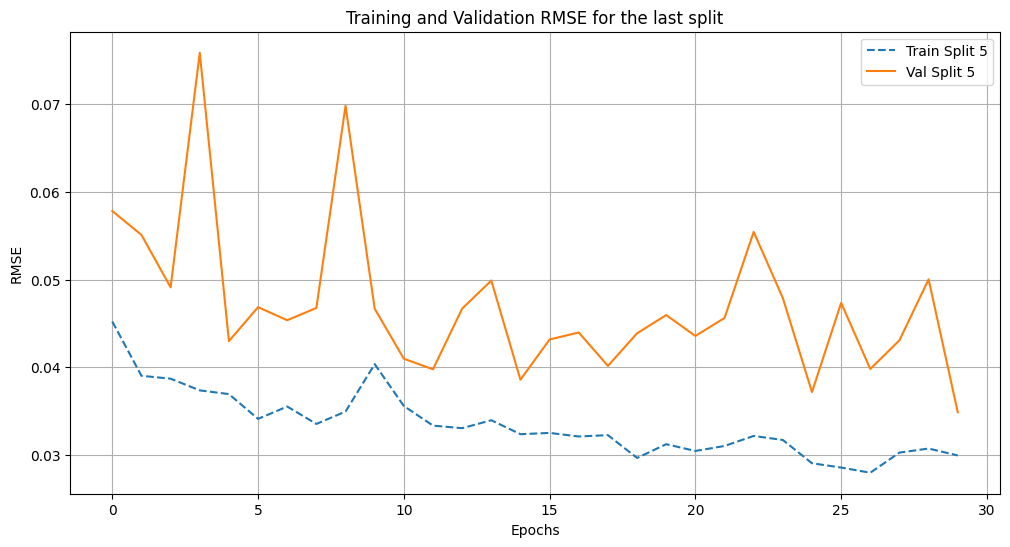

7/7 [==============================] - 0s 26ms/step - loss: 0.0011 - root_mean_squared_error: 0.0338
Test Loss: [0.0011457701912149787, 0.03384922817349434]


In [15]:
# Build the LSTM model
opt_lstm_model =  LSTM_model( units=units, dropout_rate=dropout_rate)
cross_validation(opt_lstm_model, 5, epochs, batch_size)
loss = opt_lstm_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss}")


7/7 [==============================] - 1s 18ms/step


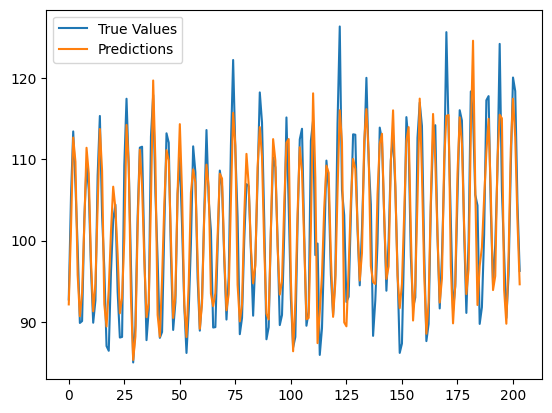

Mean Absolute Error (MAE): 3.171368593043907
Root mean sqared error(RMSE): 4.164931831023171


In [16]:
y_pred_rescaled , y_test_rescaled = predict_model(opt_lstm_model)
plot_forecasts(y_test_rescaled,y_pred_rescaled )
# Calculate error metrics
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = root_mean_squared_error(y_test_rescaled, y_pred_rescaled)

print("Mean Absolute Error (MAE):", mae)
print("Root mean sqared error(RMSE):", rmse)

The LSTM with optimal hyperparameters yields better results and lower metrics, indicating that the new hyperparameters have enhanced the model's accuracy.

#### 2- LSTM_CNN Model

The LSTM-CNN model combines the strengths of LSTM networks for capturing temporal dependencies and Convolutional Neural Networks (CNN) for extracting spatial features, making it highly effective for tasks involving both sequential and spatial data. 

In [17]:
def CNN_LSTM_model(input_shape):
    """
    Create and configure a CNN-LSTM model for time series prediction.
    :param input_shape: Shape of the input data (time_steps, features)
    :return: The configured CNN-LSTM model (keras.Sequential)
    """
    model = Sequential()

    # Add a 1D convolutional layer with 64 filters, kernel size 3, and activation function
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    
    # Add a max pooling layer to reduce the dimensionality of the output
    model.add(MaxPooling1D(pool_size=2))
    
    # Add another convolutional layer with 128 filters and kernel size 3
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    
    # Add another max pooling layer
    model.add(MaxPooling1D(pool_size=2))

    # Add LSTM layer with 50 units and return_sequences=True for multiple LSTM layers
    model.add(LSTM(units=50, return_sequences=False))

    # Add a Dropout layer for regularization
    model.add(Dropout(0.2))

    # Add a dense output layer with 1 unit (for regression tasks)
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model


Split 1:
Epoch 1/25
6/6 [==============================] - 3s 97ms/step - loss: 9.5631e-04 - val_loss: 0.0148
Epoch 2/25
6/6 [==============================] - 0s 17ms/step - loss: 3.7166e-04 - val_loss: 0.0084
Epoch 3/25
6/6 [==============================] - 0s 15ms/step - loss: 3.4531e-04 - val_loss: 0.0112
Epoch 4/25
6/6 [==============================] - 0s 16ms/step - loss: 2.7738e-04 - val_loss: 0.0093
Epoch 5/25
6/6 [==============================] - 0s 16ms/step - loss: 1.9881e-04 - val_loss: 0.0047
Epoch 6/25
6/6 [==============================] - 0s 15ms/step - loss: 1.3614e-04 - val_loss: 0.0034
Epoch 7/25
6/6 [==============================] - 0s 15ms/step - loss: 6.8278e-05 - val_loss: 0.0010
Epoch 8/25
6/6 [==============================] - 0s 14ms/step - loss: 2.2251e-05 - val_loss: 1.7596e-04
Epoch 9/25
6/6 [==============================] - 0s 15ms/step - loss: 2.3196e-05 - val_loss: 5.3906e-05
Epoch 10/25
6/6 [==============================] - 0s 17ms/step - loss: 2.

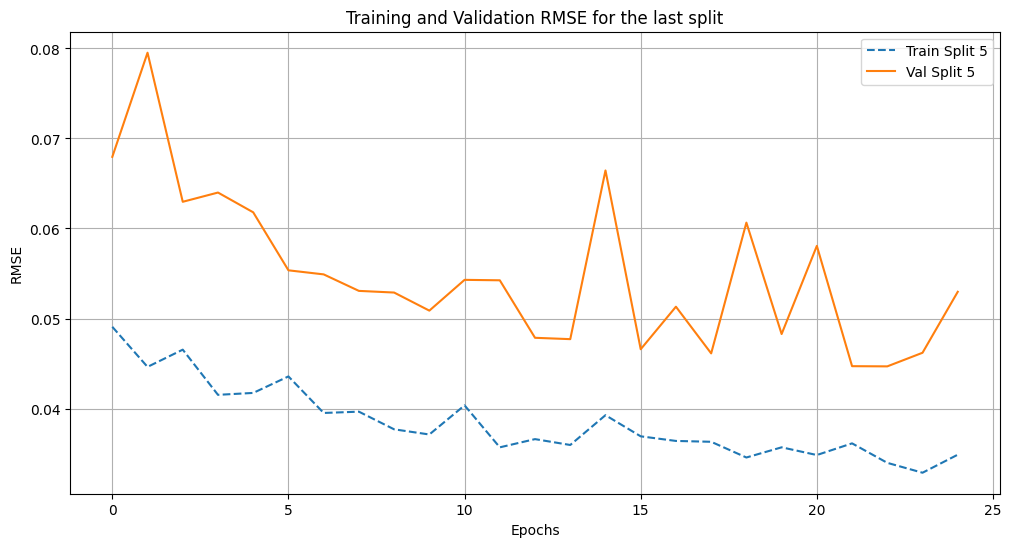

In [18]:
cnn_lstm_model = CNN_LSTM_model((X_train.shape[1], X_train.shape[2]))
cross_validation(cnn_lstm_model, 5,25,32)



In [19]:
loss = cnn_lstm_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss}")

7/7 [==============================] - 0s 3ms/step - loss: 0.0028
Test Loss: 0.0027586142532527447


7/7 [==============================] - 0s 3ms/step


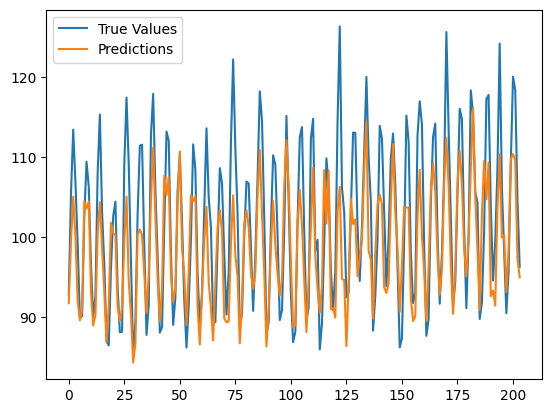

Mean Absolute Error (MAE): 5.219586159021714
Root mean sqared error(RMSE): 6.462560330246217


In [20]:
y_pred_rescaled , y_test_rescaled = predict_model(cnn_lstm_model)
plot_forecasts(y_test_rescaled,y_pred_rescaled )
# Calculate error metrics
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = root_mean_squared_error(y_test_rescaled, y_pred_rescaled)

print("Mean Absolute Error (MAE):", mae)
print("Root mean sqared error(RMSE):", rmse)

The LSTM-CNN results are lower than those of the stacked LSTM, as the metrics are higher, and the prediction curves are less accurate compared to the stacked LSTM.